In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax
from tqdm import tqdm

In [2]:
time_delay_dim = 10
time_delay = 10
time_range = (0, 600, 0.02)
n_centers = 500

In [10]:
rescale_factor = 1
stimulus = lib.lorenz1963_stimulus(time_range=time_range, rescale_factor=rescale_factor, initial_state=[-3.5, -3.0, 21.], time_constant=10,rho=28, sigma=10, beta=8/3)
stimulus.get_stimulus_list()

stimulus2 = lib.colpitts_stimulus(time_range=time_range, rescale_factor=rescale_factor*4, initial_state=[0.1, 0.1, 0.1], time_constant=5, alpha=5, gamma=0.09, eta=7.273, q=0.6898)
stimulus2.get_stimulus_list(variable_idx=1)

# stimulus2 = lib.lorenz1963_stimulus(time_range=time_range, rescale_factor=rescale_factor, initial_state=[-2.5, -3., 10], time_constant=10, rho=30, sigma=10.5, beta=8/5)
# stimulus2.get_stimulus_list()

training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

training_neuron2 = lib.single_neuron_odeint(stimulus2, [0, 0, 0, 0])
training_neuron2.generate_sol()

Text(0, 0.5, 'stimulus current colpitts')

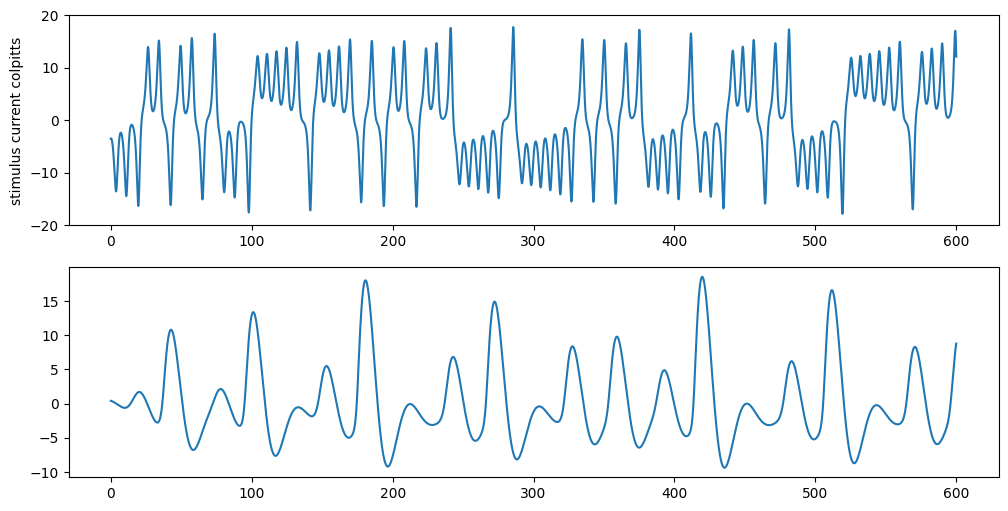

In [11]:
fig, axes = plt.subplots(2, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range), stimulus.stimulus_list)
axes[0].set_ylabel("stimulus current lorenz63")
axes[0].set_yticks([-20, -10, 0, 10, 20])
axes[1].plot(np.arange(*time_range), stimulus2.sol[:, 1])
axes[0].set_ylabel("stimulus current colpitts")

In [12]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
stimulus.stimulus_list = stimulus.stimulus_list[drop_first_n_points:]

training_neuron2.sol = training_neuron2.sol[drop_first_n_points:]
stimulus2.stimulus_list = stimulus2.stimulus_list[drop_first_n_points:]

Text(0.5, 0, 'time (ms)')

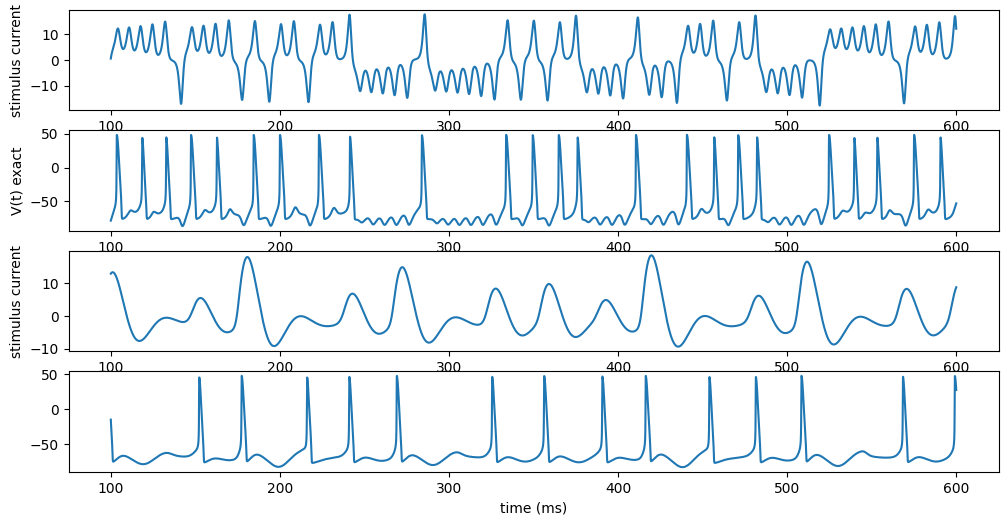

In [13]:
fig, axes = plt.subplots(4, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], stimulus.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron.sol[:, 0])
axes[1].set_ylabel("V(t) exact")
axes[2].plot(np.arange(*time_range)[drop_first_n_points:], stimulus2.stimulus_list)
axes[2].set_ylabel("stimulus current")
axes[3].plot(np.arange(*time_range)[drop_first_n_points:], training_neuron2.sol[:, 0])
axes[3].set_xlabel("time (ms)")